# Road Segmentation from Aerial Imagery

## Introduction
Road segmentation using aerial imagery is a crucial task in the field of computer vision and machine learning, particularly for applications in urban planning, autonomous driving, and geographic information systems (GIS). The challenge in this task arises from various factors including the presence of nearby trees, shadows cast by buildings, the diverse textures and colors of the roads, and the imbalance in road versus non-road areas within images.

## Objective
The main goal of this project is to develop a deep learning model capable of accurately segmenting roads from aerial images. This involves distinguishing road pixels from non-road pixels and ensuring the segmented roads are continuous and complete across the image span.

## Dataset Description
The dataset used in this project is the Massachusetts Roads Dataset, which comprises 1171 high-resolution aerial images of Massachusetts. Each image is 1500x1500 pixels, covering 2.25 square kilometers. The dataset is divided into:
- **Training Set**: 1108 images
- **Validation Set**: 14 images
- **Test Set**: 49 images

The images encompass a variety of settings, including urban, suburban, and rural areas, totaling over 2600 square kilometers, with the test set covering more than 110 square kilometers. The target road maps were created by rasterizing road centerlines from the OpenStreetMap project, with a line thickness of 7 pixels without any smoothing. The imagery is scaled to a resolution of 1 pixel per square meter.

## Challenges
Segmentation models must overcome several challenges specific to the nature of aerial imagery, such as:
- Varying lighting conditions and shadows from adjacent structures.
- Obstruction due to vegetation.
- Inherent class imbalance between road and non-road regions.

## Acknowledgements
This dataset is derived from the work presented in Volodymyr Mnih's PhD thesis, specifically introduced in Chapter 6. For any research use of this dataset, the following citation is recommended:
- [Volodymyr Mnih's PhD Thesis](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset)



In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.models.segmentation import fcn_resnet50
import torch.nn as nn
import os
from PIL import Image
import torch

import cv2
from sklearn.model_selection import train_test_split



# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to data directories
base_path = '/content/drive/My Drive/sattelite_data/'
tiff_path = os.path.join(base_path, 'tiff')
import zipfile
import os


# Load CSV files
label_class_dict = pd.read_csv(os.path.join(base_path, 'label_class_dict.csv'))
metadata = pd.read_csv(os.path.join(base_path, 'metadata.csv'))

# List files in directories to confirm structure
print("Contents of the base directory:", os.listdir(base_path))
print("Contents of the TIFF directory:", os.listdir(tiff_path))
print("Training images:", len(os.listdir(os.path.join(tiff_path, 'train'))))
print("Training labels:", len(os.listdir(os.path.join(tiff_path, 'train_labels'))))
print("Validation images:", len(os.listdir(os.path.join(tiff_path, 'val'))))
print("Validation labels:", len(os.listdir(os.path.join(tiff_path, 'val_labels'))))
print("Test images:", len(os.listdir(os.path.join(tiff_path, 'test'))))
print("Test labels:", len(os.listdir(os.path.join(tiff_path, 'test_labels'))))

# Display the first few rows of the CSV files to understand their structure and content
print("Label Class Dictionary:")
print(label_class_dict.head())
print("Metadata:")
print(metadata.head())


Contents of the base directory: ['label_class_dict.csv', 'metadata.csv', 'tiff']
Contents of the TIFF directory: ['val_labels', '.DS_Store', 'test_labels', 'test', 'train', 'train_labels', 'val']
Training images: 1108
Training labels: 1108
Validation images: 14
Validation labels: 14
Test images: 49
Test labels: 49
Label Class Dictionary:
         name    r    g    b
0  background    0    0    0
1        road  255  255  255
Metadata:
      image_id  split                                    image_souce_url  \
0  10078660_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_roa...   
1  10078675_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_roa...   
2  10078690_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_roa...   
3  10078705_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_roa...   
4  10078720_15  train  http://www.cs.toronto.edu/~vmnih/data/mass_roa...   

                                    label_source_url  \
0  http://www.cs.toronto.edu/~vmnih/data/mass_roa.

In [ ]:
# Parsing the label_class_dict.csv
label_class_dict = pd.read_csv(os.path.join(base_path, 'label_class_dict.csv'))

# Displaying the label_class_dict
print(label_class_dict)

# Creating a dictionary to map label names to RGB values
label_to_rgb = {
    row['name']: (row['r'], row['g'], row['b'])
    for _, row in label_class_dict.iterrows()
}

# Creating a dictionary to map RGB values to label names
rgb_to_label = {
    (row['r'], row['g'], row['b']): row['name']
    for _, row in label_class_dict.iterrows()
}

print("Label to RGB Mapping:")
print(label_to_rgb)

print("RGB to Label Mapping:")
print(rgb_to_label)


         name    r    g    b
0  background    0    0    0
1        road  255  255  255
Label to RGB Mapping:
{'background': (0, 0, 0), 'road': (255, 255, 255)}
RGB to Label Mapping:
{(0, 0, 0): 'background', (255, 255, 255): 'road'}


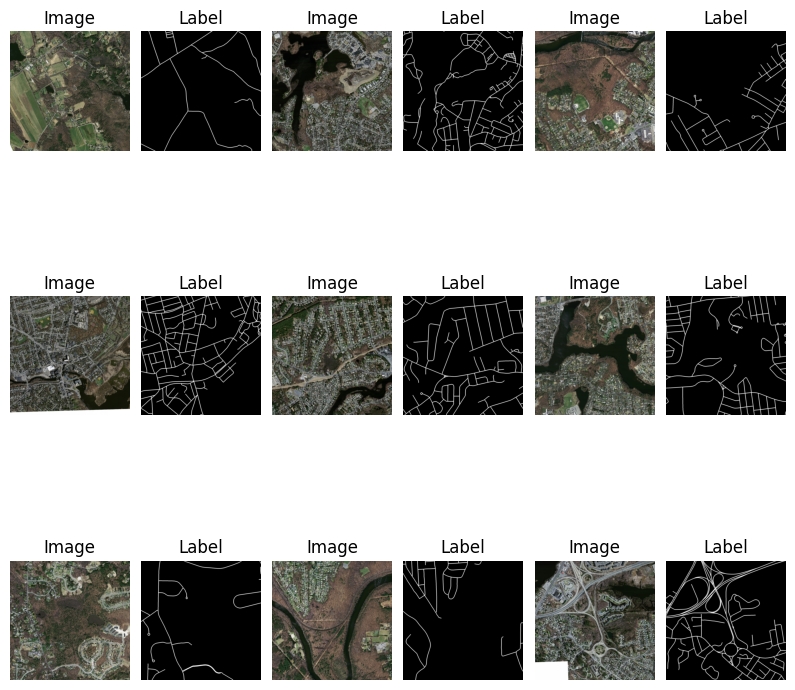

In [ ]:
# Paths for images and masks
image_dir = '/content/drive/My Drive/sattelite_data/tiff/train'
mask_dir = '/content/drive/My Drive/sattelite_data/tiff/train_labels'
# Function to plot example images and labels with matching names
def plot_examples(rows=3, cols=3):
    fig, axs = plt.subplots(nrows=rows, ncols=cols*2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    img_names = sorted(os.listdir(image_dir))
    label_names = sorted(os.listdir(mask_dir))

    for i in range(rows):
        for j in range(cols):
            # Randomly select an image
            idx = np.random.randint(len(img_names))
            img_name = img_names[idx]
            label_name = label_names[idx]

            # Load image and label
            img = cv2.imread(os.path.join(image_dir, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label = cv2.imread(os.path.join(mask_dir, label_name), cv2.IMREAD_GRAYSCALE)

            # Display image
            axs[i, j*2].imshow(img)
            axs[i, j*2].axis('off')
            axs[i, j*2].set_title('Image')

            # Display label
            axs[i, j*2+1].imshow(label, cmap='gray')
            axs[i, j*2+1].axis('off')
            axs[i, j*2+1].set_title('Label')

    plt.show()

plot_examples()

In [ ]:
def analyze_class_distribution():
    num_road_pixels = 0
    num_background_pixels = 0

    for label_name in os.listdir(os.path.join(tiff_path, 'test_labels')):
        label = cv2.imread(os.path.join(tiff_path, 'test_labels', label_name), cv2.IMREAD_GRAYSCALE)
        num_road_pixels += np.sum(label == 255)
        num_background_pixels += np.sum(label == 0)

    total_pixels = num_road_pixels + num_background_pixels
    print("Percentage of road pixels:", (num_road_pixels / total_pixels) * 100)
    print("Percentage of background pixels:", (num_background_pixels / total_pixels) * 100)

analyze_class_distribution()


Percentage of road pixels: 4.698734693877551
Percentage of background pixels: 95.30126530612245


In [ ]:
def image_statistics():
    brightness = []
    contrast = []

    for img_name in os.listdir(os.path.join(tiff_path, 'test')):
        img = cv2.imread(os.path.join(tiff_path, 'test', img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness.append(np.mean(img))
        contrast.append(np.std(img))

    print("Average brightness:", np.mean(brightness))
    print("Average contrast:", np.mean(contrast))

image_statistics()


Average brightness: 85.5328582494331
Average contrast: 44.17601459942539


In [ ]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = {f.split('_')[0]: f for f in os.listdir(mask_dir)}  # Create a dictionary to match images to masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_base = img_name.split('_')[0]  # Assuming the unique part of each filename precedes '_'

        img_path = os.path.join(self.image_dir, img_name)
        mask_name = self.masks.get(img_base)
        if not mask_name:
            raise FileNotFoundError(f"No mask found for image {img_name}")

        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = RoadSegmentationDataset(
    image_dir='/content/drive/My Drive/sattelite_data/tiff/train',
    mask_dir='/content/drive/My Drive/sattelite_data/tiff/train_labels',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def create_unet_resnet50(pretrained=True, num_classes=1):
    model = models.segmentation.fcn_resnet50(pretrained=pretrained)
    model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    return model

# Initialize the model
model = create_unet_resnet50(pretrained=True, num_classes=1)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to train the model and save the best checkpoint
def train_model(num_epochs):
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Save the best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Best model saved with loss: {:.4f}'.format(best_loss))

train_model(15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Loss: 0.1639
Best model saved with loss: 0.1639
Epoch 2/15, Loss: 0.1003
Best model saved with loss: 0.1003
Epoch 3/15, Loss: 0.0927
Best model saved with loss: 0.0927
Epoch 4/15, Loss: 0.0892
Best model saved with loss: 0.0892
Epoch 5/15, Loss: 0.0863
Best model saved with loss: 0.0863
Epoch 6/15, Loss: 0.0842
Best model saved with loss: 0.0842
Epoch 7/15, Loss: 0.0816
Best model saved with loss: 0.0816
Epoch 8/15, Loss: 0.0792
Best model saved with loss: 0.0792
Epoch 9/15, Loss: 0.0770
Best model saved with loss: 0.0770
Epoch 10/15, Loss: 0.0741
Best model saved with loss: 0.0741
Epoch 11/15, Loss: 0.0715
Best model saved with loss: 0.0715
Epoch 12/15, Loss: 0.0694
Best model saved with loss: 0.0694
Epoch 13/15, Loss: 0.0669
Best model saved with loss: 0.0669
Epoch 14/15, Loss: 0.0658
Best model saved with loss: 0.0658
Epoch 15/15, Loss: 0.0636
Best model saved with loss: 0.0636


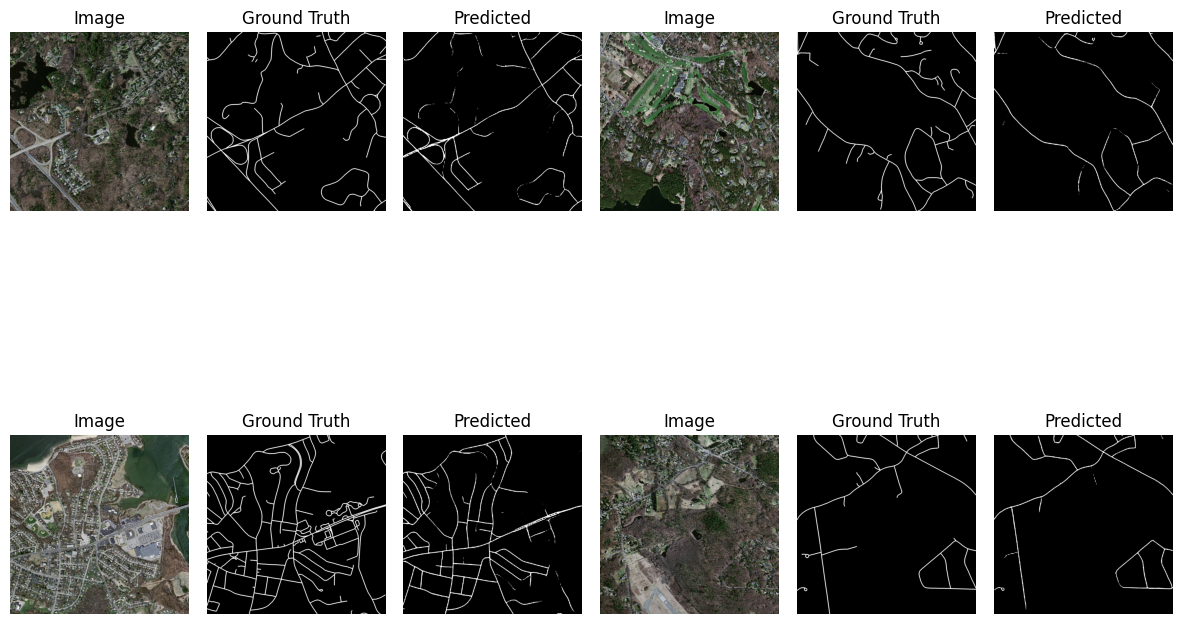

In [19]:
test_image_dir = '/content/drive/My Drive/sattelite_data/tiff/test'
test_mask_dir = '/content/drive/My Drive/sattelite_data/tiff/test_labels'
test_dataset = RoadSegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Function to plot example images, ground truth masks, and predicted masks
def plot_examples(rows=2, cols=2):
    model.eval()
    fig, axs = plt.subplots(nrows=rows, ncols=cols*3, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i in range(rows):
        for j in range(cols):
            # Load image and label
            img, gt_mask = test_dataset[i * cols + j]
            img = img.unsqueeze(0).to(device)
            gt_mask = gt_mask.squeeze().cpu().numpy()

            # Get model prediction
            with torch.no_grad():
                pred_mask = model(img)['out']
                pred_mask = torch.sigmoid(pred_mask).cpu().numpy()[0, 0]
                pred_mask = (pred_mask > 0.5).astype(np.uint8)

            img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)

            # Display image
            axs[i, j*3].imshow(img)
            axs[i, j*3].axis('off')
            axs[i, j*3].set_title('Image')

            # Display ground truth mask
            axs[i, j*3+1].imshow(gt_mask, cmap='gray')
            axs[i, j*3+1].axis('off')
            axs[i, j*3+1].set_title('Ground Truth')

            # Display predicted mask
            axs[i, j*3+2].imshow(pred_mask, cmap='gray')
            axs[i, j*3+2].axis('off')
            axs[i, j*3+2].set_title('Predicted')

    plt.show()

plot_examples()

In [20]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Function to evaluate the model and print metrics
def evaluate_model():
    model.eval()
    iou_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outputs = model(images)['out']
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(np.uint8)
            masks = masks.cpu().numpy()

        for pred, mask in zip(preds, masks):
            pred_flat = pred.flatten()
            mask_flat = mask.flatten()
            iou_scores.append(jaccard_score(mask_flat, pred_flat, average='binary'))
            precision_scores.append(precision_score(mask_flat, pred_flat, average='binary'))
            recall_scores.append(recall_score(mask_flat, pred_flat, average='binary'))
            f1_scores.append(f1_score(mask_flat, pred_flat, average='binary'))

    print(f"Mean IoU: {np.mean(iou_scores):.4f}")
    print(f"Mean Precision: {np.mean(precision_scores):.4f}")
    print(f"Mean Recall: {np.mean(recall_scores):.4f}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")

# Evaluate the model
evaluate_model()

Mean IoU: 0.5127
Mean Precision: 0.7885
Mean Recall: 0.5953
Mean F1 Score: 0.6730


### Results
After training the FCN-ResNet50 model for 15 epochs on the road segmentation dataset, the model achieved the following performance metrics on the test dataset:

- Mean IoU (Intersection over Union): 0.5127
- Mean Precision: 0.7885
- Mean Recall: 0.5953
- Mean F1 Score: 0.6730

### Discussion
The results indicate a reasonably good performance of the model, especially in terms of precision, where the model correctly identified road pixels with high accuracy (0.7885). However, the recall score of 0.5953 suggests that the model missed some road pixels, which is reflected in the mean IoU of 0.5127 and the mean F1 score of 0.6730.

### Challenges:

1. Thin and Irregular Road Segments: The lower IoU score can be attributed to the thin and irregular nature of road segments in the aerial images. Roads often appear as narrow lines, which can be challenging for segmentation models to capture accurately. Small errors in predicting these narrow lines can significantly impact the IoU score.

2. Class Imbalance: There might be an imbalance between the number of road pixels and background pixels in the dataset. If the majority of pixels belong to the background class, the model might be biased towards predicting the background, leading to higher precision but lower recall.

3. Resolution and Scale Variability: The variability in resolution and scale of different road sections can also affect the model's performance. Roads in some images might appear very different in terms of width and visibility compared to others, making it harder for the model to generalize.

### Conclusion
The FCN-ResNet50 model shows promise in segmenting roads from aerial images, achieving good precision but facing challenges with recall and IoU due to the nature of the data. Here are some potential steps to improve performance:

- Data Augmentation: Applying data augmentation techniques such as rotation, scaling, and flipping could help the model generalize better to various road shapes and orientations.

- Class Weighting: Applying class weighting in the loss function can help address class imbalance, ensuring the model pays more attention to the underrepresented road pixels.

- Post-processing: Implementing post-processing techniques such as morphological operations could help refine the predicted road segments and improve the overall IoU.

- Model Architecture: Exploring more advanced segmentation architectures like U-Net, DeepLabV3+, or models specifically designed for thin object segmentation might yield better results.

- Resolution Adjustment: Training the model on higher resolution images or incorporating multi-scale features could help in better capturing the thin and detailed road structures.

- Despite the challenges, the current results provide a solid baseline and indicate areas for further exploration and improvement. The project demonstrates the feasibility of using deep learning models for road segmentation and highlights the importance of addressing specific data characteristics in such tasks.